In [5]:
from google.colab import files
uploaded = files.upload()


Saving encoded_data.csv to encoded_data (1).csv
Saving Quantitave stand and filled gaps.csv to Quantitave stand and filled gaps (1).csv
Saving TRAINING_SOLUTIONS.xlsx to TRAINING_SOLUTIONS.xlsx


In [11]:
import pandas as pd
import numpy as np

train_quantitative = pd.read_csv('Quantitave stand and filled gaps.csv')
train_categorial=pd.read_csv('encoded_data.csv')
# Read the Excel files
training_solutions = pd.read_excel('TRAINING_SOLUTIONS.xlsx')


print("\nTrain Quantitative Metadata:")
print(train_quantitative.head())


print("\nTrain Categorial Metadata:")
print(train_categorial.head())

print("\nTraining Solutions:")
print(training_solutions.head())



Train Quantitative Metadata:
  participant_id  EHQ_EHQ_Total  ColorVision_CV_Score  APQ_P_APQ_P_CP  \
0   0Hthz5IFXhpw        0.96135                   1.0             0.3   
1   0i2Tz2XUL4vm        0.93335                   1.0             0.1   
2   18K8e924IXlw        0.30000                   1.0             0.1   
3   19wn6hMP5wTE        0.95000                   1.0             0.1   
4   1exRTCGiAbwI        1.00000                   1.0             0.1   

   APQ_P_APQ_P_ID  APQ_P_APQ_P_INV  APQ_P_APQ_P_OPD  APQ_P_APQ_P_PM  \
0        0.130435         0.148148         0.476190         0.21875   
1        0.391304         0.851852         0.428571         0.15625   
2        0.304348         0.518519         0.428571         0.37500   
3        0.304348         0.777778         0.523810         0.18750   
4        0.739130         0.481481         0.619048         0.50000   

   APQ_P_APQ_P_PP  SDQ_SDQ_Conduct_Problems  ...  SDQ_SDQ_Emotional_Problems  \
0        0.529412       

### 1. Mann-Whitney U Test + Cliff's Delta for Quantitative Features


#### What is the Mann-Whitney U Test and How is it Used Here?
The Mann-Whitney U Test is a non-parametric statistical test used to compare the distributions of two independent groups based on quantitative (numerical) data, especially when the data does not necessarily follow a normal distribution. It tests whether the values in one group tend to be higher or lower than those in the other group.

Here, we apply the Mann-Whitney U Test to each quantitative feature, comparing participants with and without ADHD. The test produces a p-value indicating whether the difference between the two groups for that feature is statistically significant. This helps identify which numerical features are potentially associated with ADHD outcomes.

#### what is Cliff’s Delta and Why is it Used Here?
Cliff’s Delta is a non-parametric measure of effect size used for quantitative data. It quantifies how much two groups differ by calculating the number of times a value from one group is higher than a value from the other group, minus the number of times it’s lower. In other words, it gives an intuitive sense of the magnitude of the difference between two groups.


#### Why Use Both Mann-Whitney U Test and Cliff’s Delta Together?
When comparing two groups of quantitative data, it’s important to assess both statistical significance and practical significance:

*   The Mann-Whitney U Test tells us whether a statistically significant difference exists between the distributions of two independent groups. It’s especially useful when the data is not normally distributed or when dealing with ordinal or skewed numerical data.
*   Cliff’s Delta complements this by measuring the effect size — it quantifies how big or meaningful the difference is between the two groups. This is valuable because a statistically significant result might still have a very small effect size, especially in large samples.


Using both together ensures a more complete and reliable interpretation:

* The Mann-Whitney U Test answers: *“Is there a difference?”*

* Cliff’s Delta answers: *“How big is that difference?”*

This combination prevents over-reliance on p-values alone and highlights whether observed differences are both statistically and practically important.

In [14]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu

# Cliff's Delta function
def cliffs_delta(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    deltas = np.sign(x[:, None] - y).mean()
    return deltas

# Interpretation of Cliff's Delta
def interpret_cliffs_delta(delta):
    d = abs(delta)
    if d < 0.11: return 'Very Small'
    elif d < 0.28: return 'Small'
    elif d < 0.43: return 'Medium'
    else: return 'Large'

# Interpretation of Mann-Whitney U p-value
def interpret_p_value(p_value):
    return "Significant" if p_value < 0.05 else "Not Significant"

# Merge quantitative features with target
quant_merged = pd.merge(train_quantitative, training_solutions, on='participant_id')

# Identify which ADHD outcome column exists
adhd_cols = [col for col in quant_merged.columns if 'ADHD_Outcome' in col]
if not adhd_cols:
    raise ValueError("No ADHD_Outcome column found after merge.")
adhd_col = adhd_cols[0]  # use the first one found
print(f"Using '{adhd_col}' as ADHD outcome column.")

# Select numeric columns
numeric_cols = quant_merged.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns before dropping:", numeric_cols)

# Drop Sex_F and both ADHD outcomes columns
cols_to_drop = [col for col in numeric_cols if 'ADHD_Outcome' in col or 'Sex_F' in col]
quant_features = quant_merged.select_dtypes(include=[np.number]).drop(columns=cols_to_drop)
print("Numeric columns after dropping:", quant_features.columns.tolist())

# Run statistical tests
results = []

for col in quant_features.columns:
    group0 = quant_merged[quant_merged[adhd_col] == 0][col].dropna()
    group1 = quant_merged[quant_merged[adhd_col] == 1][col].dropna()

    if len(group0) > 0 and len(group1) > 0:
        # Mann-Whitney U Test
        stat, p_value = mannwhitneyu(group0, group1, alternative='two-sided')

        # Cliff's Delta
        delta = cliffs_delta(group0.values, group1.values)

        # Interpret results
        effect_size = interpret_cliffs_delta(delta)
        significance = interpret_p_value(p_value)

        results.append({
            'Feature': col,
            'Mann-Whitney U p-value': round(p_value, 5),
            'Significance': significance,
            "Cliff's Delta": round(delta, 5),
            "Effect Size": effect_size
        })

quant_stats_df = pd.DataFrame(results).sort_values('Mann-Whitney U p-value')
print(quant_stats_df)


Using 'ADHD_Outcome_x' as ADHD outcome column.
Numeric columns before dropping: ['EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan', 'ADHD_Outcome_x', 'Sex_F_x', 'ADHD_Outcome_y', 'Sex_F_y']
Numeric columns after dropping: ['EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan']


### 2. Chi-Square Test + Cramér's V for Categorical Features


#### What is the Chi-Square Test and How is it Used Here?
The Chi-Square Test of Independence is a statistical test used to determine whether there’s a significant association between two categorical variables. It compares the observed frequencies in each category combination with the expected frequencies if the two variables were independent.

Here, the Chi-Square test is applied to contingency tables built from each categorical feature and the ADHD outcome. It produces a p-value indicating whether there’s a statistically significant relationship between the feature and the ADHD diagnosis. This helps us identify categorical variables that are potentially associated with ADHD outcomes.



#### What is Cramér’s V and Why is it Used Here?
Cramér’s V is a measure of effect size for categorical data, used to quantify the strength of association between two variables in a contingency table. It ranges from 0 (no association) to 1 (perfect association). Unlike the Chi-Square test, which only tells us if a relationship exists, Cramér’s V indicates how strong that relationship is.

Here, after performing the Chi-Square test, we calculate Cramér’s V for the same contingency tables to assess the practical importance of any significant associations. This is especially useful when significant p-values are found, helping interpret whether those differences are meaningful in practice.



#### Why Use Both Chi-Square and Cramér’s V Together?
Using both the Chi-Square test and Cramér’s V provides a complete picture when analyzing categorical variables:

* The Chi-Square test tells us whether there’s a statistically significant relationship between a feature and the ADHD outcome (via the p-value).

* Cramér’s V then measures the strength of that relationship, offering a practical interpretation of how strongly the two variables are associated.

This combination ensures that we don’t rely solely on p-values — which can be significant even for trivial associations in large samples — and instead also consider the effect size, giving more context and clarity to our analysis.

In [23]:
from scipy.stats import chi2_contingency

# Extract participant ID from one-hot encoded columns
# Extract participant ID from one-hot encoded columns
participant_columns = [col for col in train_categorial.columns if col.startswith('participant_id_')]
participant_ids = [col.replace('participant_id_', '') for col in participant_columns]


cat_merged = pd.merge(train_categorial, training_solutions, on='participant_id')

for col in train_categorial.columns:
    if col != 'participant_id':
        cat_merged[col] = cat_merged[col].astype(str)

# Cramér's V function
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corr = max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1))
    r_corr = r - ((r - 1)**2) / (n - 1)
    k_corr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2_corr / min((k_corr - 1), (r_corr - 1)))

# Interpretation functions
def interpret_p_value(p_value):
    return "Significant" if p_value < 0.05 else "Not Significant"

def interpret_cramers_v(v_value):
    if v_value < 0.1:
        return "Negligible"
    elif v_value < 0.3:
        return "Small"
    elif v_value < 0.5:
        return "Medium"
    else:
        return "Large"

cat_results = []

exclude_columns = ['participant_id'] + \
    [col for col in train_categorial.columns if col.startswith('ADHD_Outcome_')] + \
    [col for col in train_categorial.columns if col.startswith('Sex_F_')]

for col in train_categorial.columns:
    if col in exclude_columns:
        continue


for col in train_categorial.columns:
    if col in exclude_columns:
        continue

    contingency_table = pd.crosstab(cat_merged[col], cat_merged['ADHD_Outcome'])

    if contingency_table.shape[0] > 1:  # Skip columns with no variability
        chi2, p, _, _ = chi2_contingency(contingency_table)
        cramer_v = cramers_v(contingency_table)

        significance = interpret_p_value(p)
        cramer_v_interpretation = interpret_cramers_v(cramer_v)

        cat_results.append({
            'Feature': col,
            'Chi2 p-value': round(p, 5),
            'Significance': significance,
            "Cramér's V": round(cramer_v, 5),
            "Cramér's V Interpretation": cramer_v_interpretation
        })

cat_stats_df = pd.DataFrame(cat_results).sort_values('Chi2 p-value')

# Display results
print(cat_stats_df)


                            Feature  Chi2 p-value     Significance  \
1      Basic_Demos_Enroll_Year_2016       0.00000      Significant   
20      MRI_Track_Scan_Location_1.0       0.00000      Significant   
22      MRI_Track_Scan_Location_3.0       0.00002      Significant   
3      Basic_Demos_Enroll_Year_2018       0.00040      Significant   
6          Basic_Demos_Study_Site_1       0.00180      Significant   
..                              ...           ...              ...   
19  PreInt_Demos_Fam_Child_Race_9.0       1.00000  Not Significant   
42       Barratt_Barratt_P1_Occ_5.0       1.00000  Not Significant   
41      Barratt_Barratt_P1_Occ_45.0       1.00000  Not Significant   
50       Barratt_Barratt_P2_Edu_9.0       1.00000  Not Significant   
48       Barratt_Barratt_P2_Edu_3.0       1.00000  Not Significant   

    Cramér's V Cramér's V Interpretation  
1      0.16497                     Small  
20     0.13786                     Small  
22     0.11830                

#### Check Multicollinearity
We calculate the Variance Inflation Factor (VIF) to check for multicollinearity, where high multicollinearity can cause problems in statistical models by making it hard to interpret the effect of each feature and can lead to unstable estimates. By identifying features with high VIF values, we can decide to remove or combine them to improve the reliability and performance of our models.



EHQ_EHQ_Total                 float64
ColorVision_CV_Score          float64
APQ_P_APQ_P_CP                float64
APQ_P_APQ_P_ID                float64
APQ_P_APQ_P_INV               float64
APQ_P_APQ_P_OPD               float64
APQ_P_APQ_P_PM                float64
APQ_P_APQ_P_PP                float64
SDQ_SDQ_Conduct_Problems      float64
SDQ_SDQ_Difficulties_Total    float64
SDQ_SDQ_Emotional_Problems    float64
SDQ_SDQ_Externalizing         float64
SDQ_SDQ_Generating_Impact     float64
SDQ_SDQ_Hyperactivity         float64
SDQ_SDQ_Internalizing         float64
SDQ_SDQ_Peer_Problems         float64
SDQ_SDQ_Prosocial             float64
MRI_Track_Age_at_Scan         float64
dtype: object

 Variance Inflation Factors
                       Feature        VIF
9   SDQ_SDQ_Difficulties_Total        inf
8     SDQ_SDQ_Conduct_Problems        inf
14       SDQ_SDQ_Internalizing        inf
13       SDQ_SDQ_Hyperactivity        inf
11       SDQ_SDQ_Externalizing        inf
15       SDQ_SDQ_Peer

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


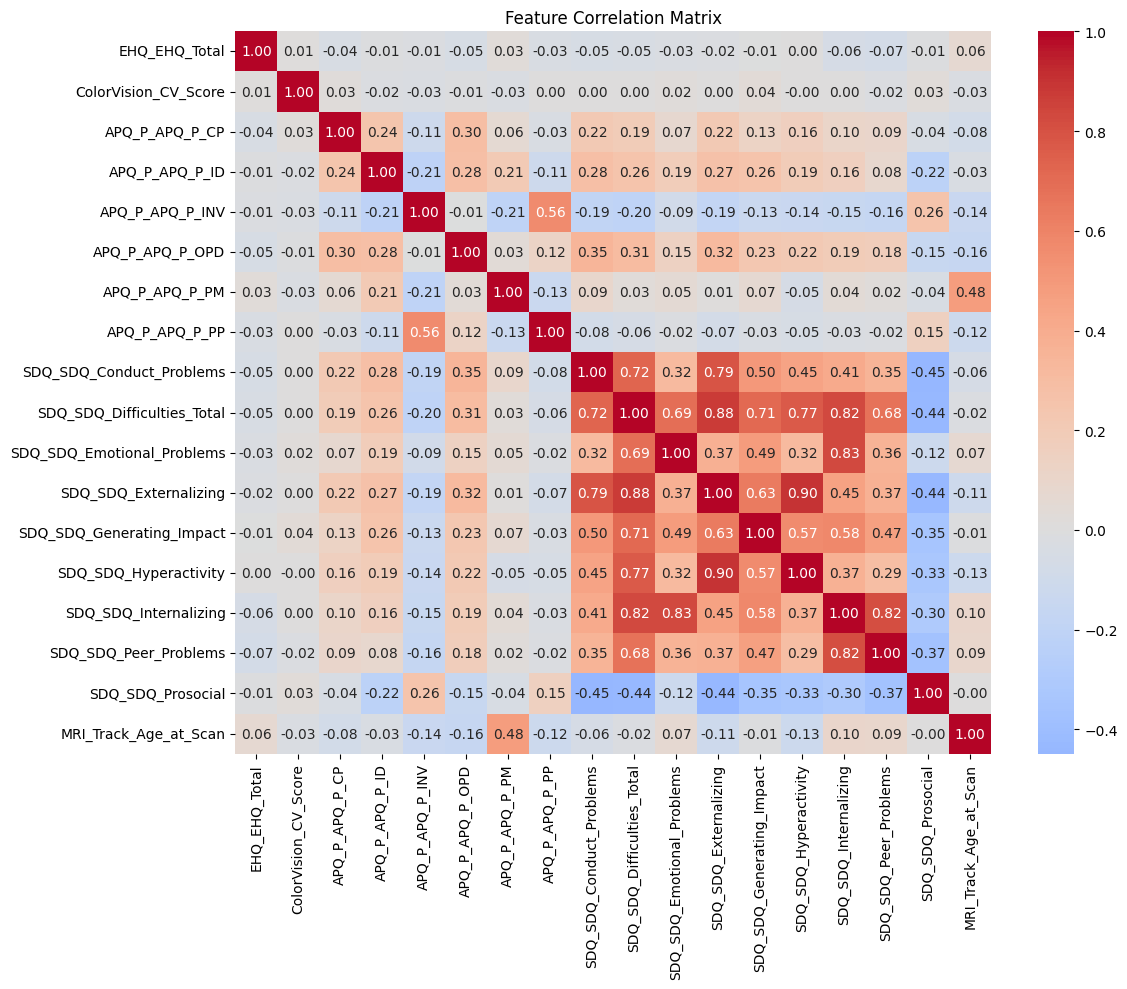

In [31]:
# Check for NaNs or inf values
X_clean = X.replace([np.inf, -np.inf], np.nan).dropna()

# Check if columns are numeric
print(X_clean.dtypes)

# calculate VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = X_clean.columns
vif_data['VIF'] = [variance_inflation_factor(X_clean.values, i) for i in range(X_clean.shape[1])]

print("\n Variance Inflation Factors")
print(vif_data.sort_values('VIF', ascending=False))

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(X_clean.corr(), annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()


<ipython-input-37-03e497a9ebd7>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group0, label="ADHD = 0", shade=True)
<ipython-input-37-03e497a9ebd7>:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group1, label="ADHD = 1", shade=True)


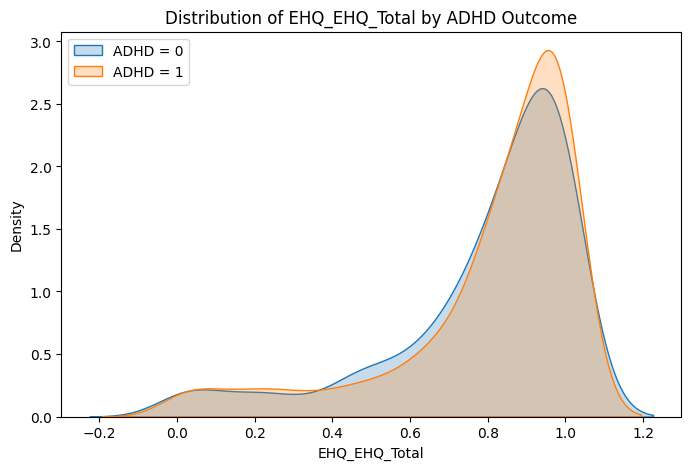

<ipython-input-37-03e497a9ebd7>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group0, label="ADHD = 0", shade=True)
<ipython-input-37-03e497a9ebd7>:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group1, label="ADHD = 1", shade=True)


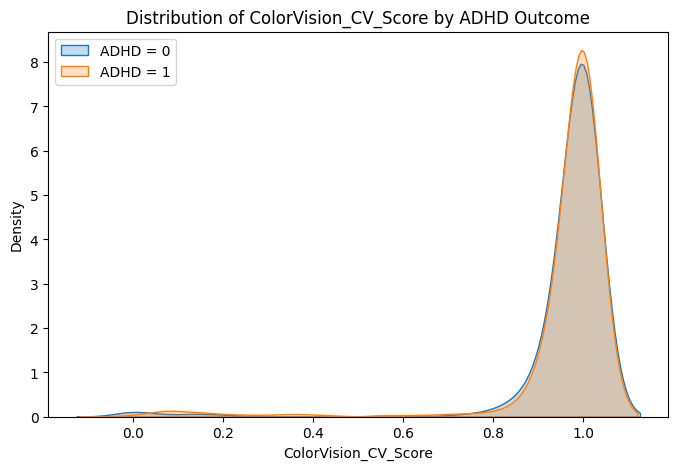

<ipython-input-37-03e497a9ebd7>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group0, label="ADHD = 0", shade=True)
<ipython-input-37-03e497a9ebd7>:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group1, label="ADHD = 1", shade=True)


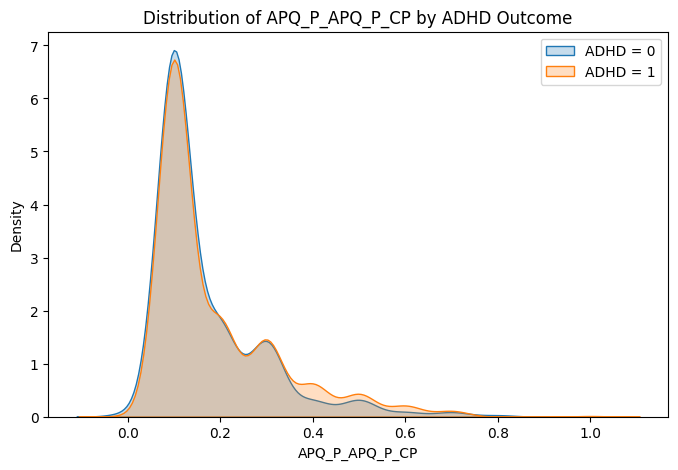

<ipython-input-37-03e497a9ebd7>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group0, label="ADHD = 0", shade=True)
<ipython-input-37-03e497a9ebd7>:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group1, label="ADHD = 1", shade=True)


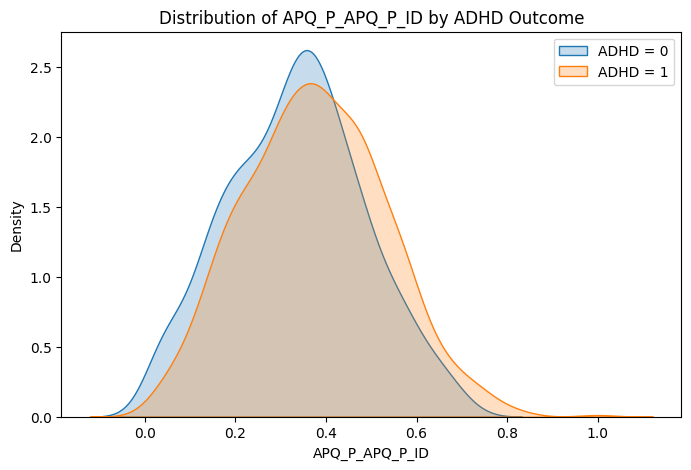

<ipython-input-37-03e497a9ebd7>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group0, label="ADHD = 0", shade=True)
<ipython-input-37-03e497a9ebd7>:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group1, label="ADHD = 1", shade=True)


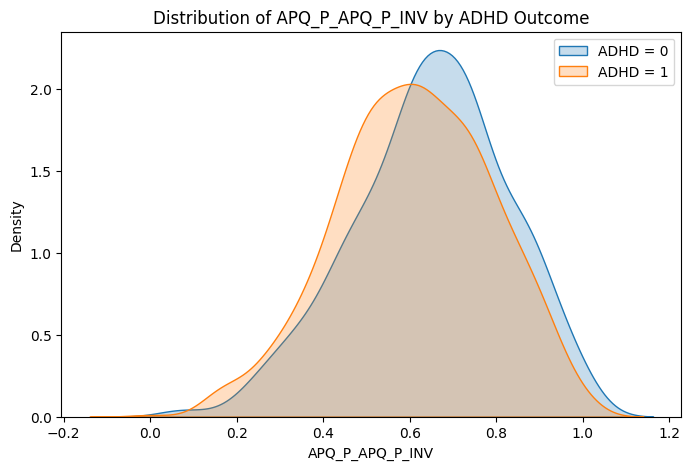

<ipython-input-37-03e497a9ebd7>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group0, label="ADHD = 0", shade=True)
<ipython-input-37-03e497a9ebd7>:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group1, label="ADHD = 1", shade=True)


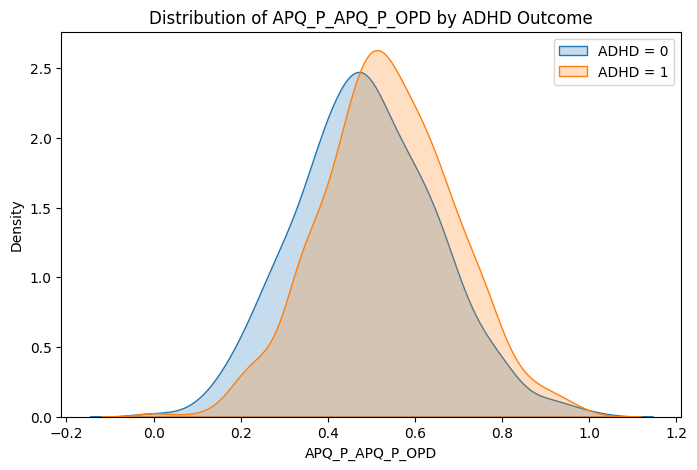

<ipython-input-37-03e497a9ebd7>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group0, label="ADHD = 0", shade=True)
<ipython-input-37-03e497a9ebd7>:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group1, label="ADHD = 1", shade=True)


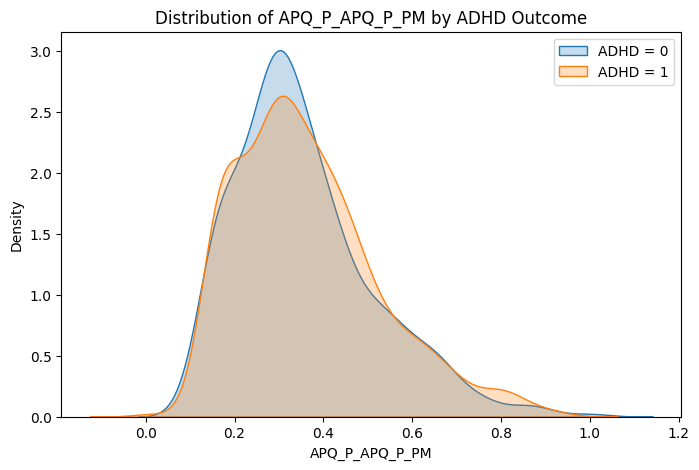

<ipython-input-37-03e497a9ebd7>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group0, label="ADHD = 0", shade=True)
<ipython-input-37-03e497a9ebd7>:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group1, label="ADHD = 1", shade=True)


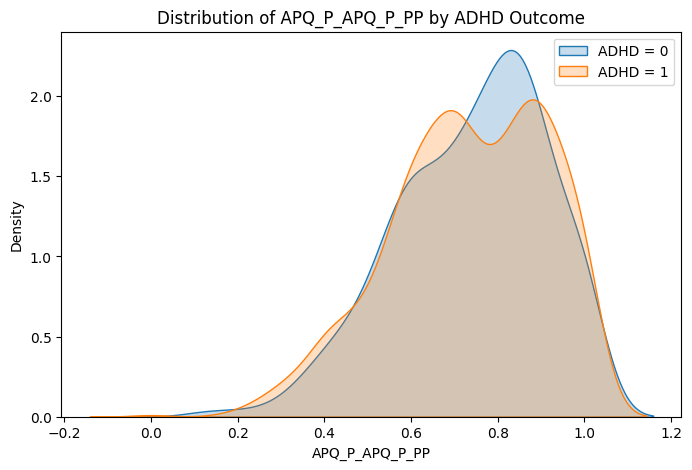

<ipython-input-37-03e497a9ebd7>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group0, label="ADHD = 0", shade=True)
<ipython-input-37-03e497a9ebd7>:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group1, label="ADHD = 1", shade=True)


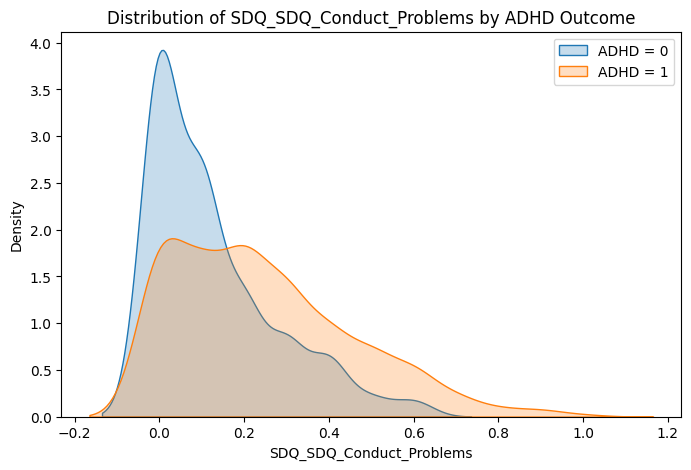

<ipython-input-37-03e497a9ebd7>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group0, label="ADHD = 0", shade=True)
<ipython-input-37-03e497a9ebd7>:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group1, label="ADHD = 1", shade=True)


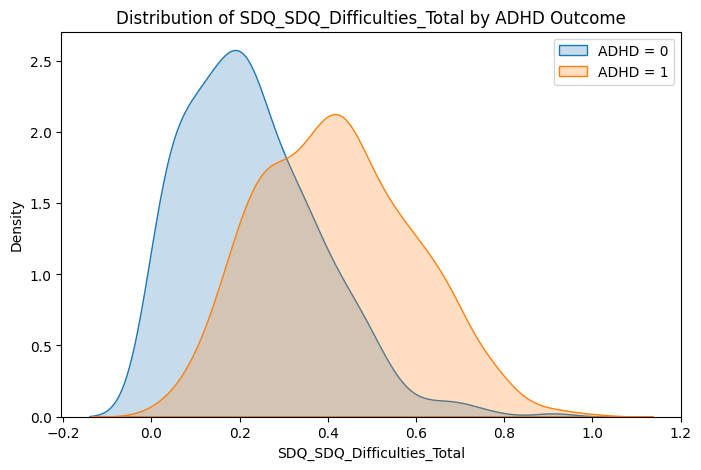

<ipython-input-37-03e497a9ebd7>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group0, label="ADHD = 0", shade=True)
<ipython-input-37-03e497a9ebd7>:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group1, label="ADHD = 1", shade=True)


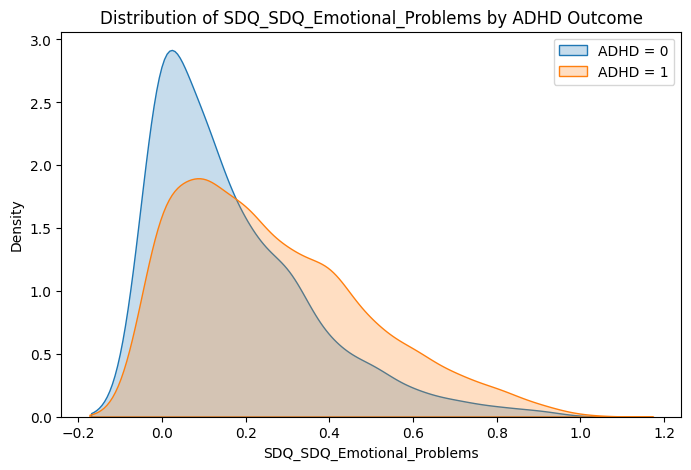

<ipython-input-37-03e497a9ebd7>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group0, label="ADHD = 0", shade=True)
<ipython-input-37-03e497a9ebd7>:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group1, label="ADHD = 1", shade=True)


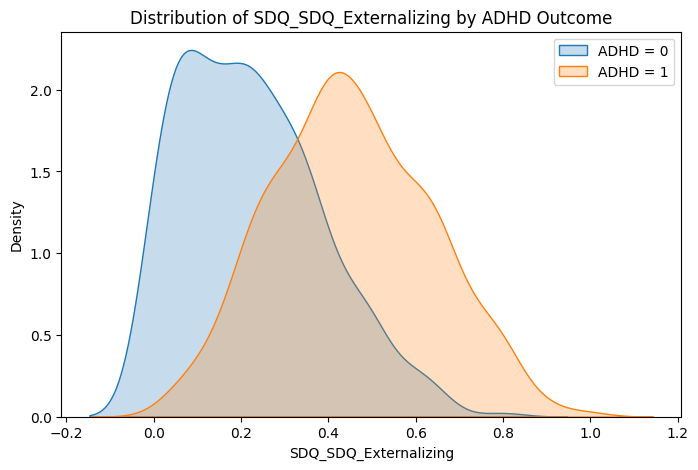

<ipython-input-37-03e497a9ebd7>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group0, label="ADHD = 0", shade=True)
<ipython-input-37-03e497a9ebd7>:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group1, label="ADHD = 1", shade=True)


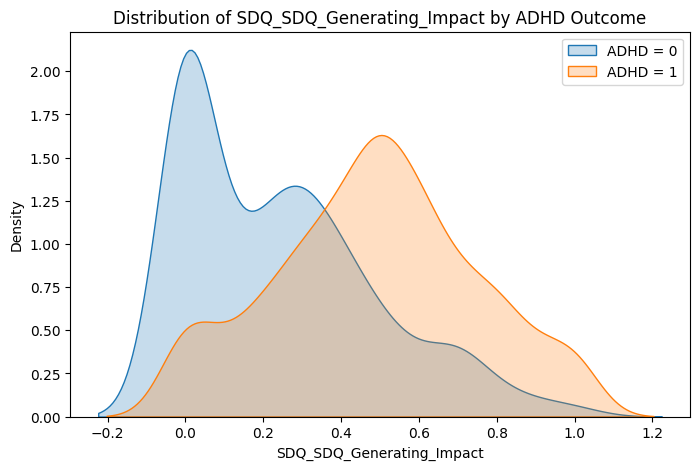

<ipython-input-37-03e497a9ebd7>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group0, label="ADHD = 0", shade=True)
<ipython-input-37-03e497a9ebd7>:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group1, label="ADHD = 1", shade=True)


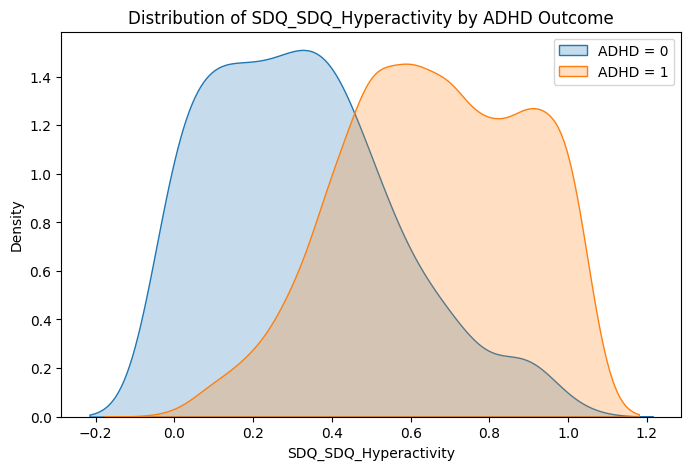

<ipython-input-37-03e497a9ebd7>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group0, label="ADHD = 0", shade=True)
<ipython-input-37-03e497a9ebd7>:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group1, label="ADHD = 1", shade=True)


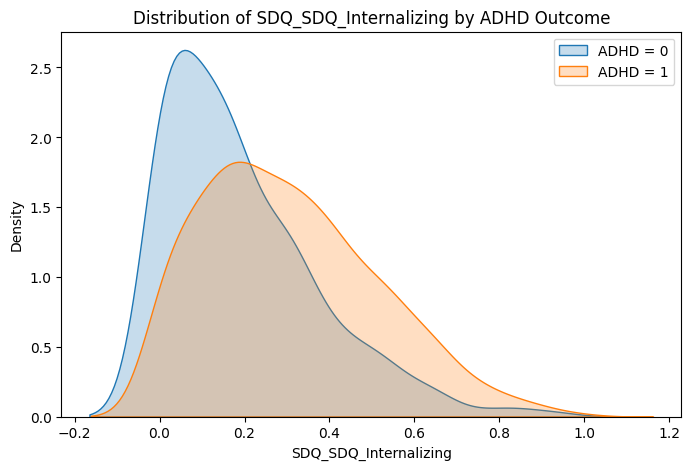

<ipython-input-37-03e497a9ebd7>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group0, label="ADHD = 0", shade=True)
<ipython-input-37-03e497a9ebd7>:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group1, label="ADHD = 1", shade=True)


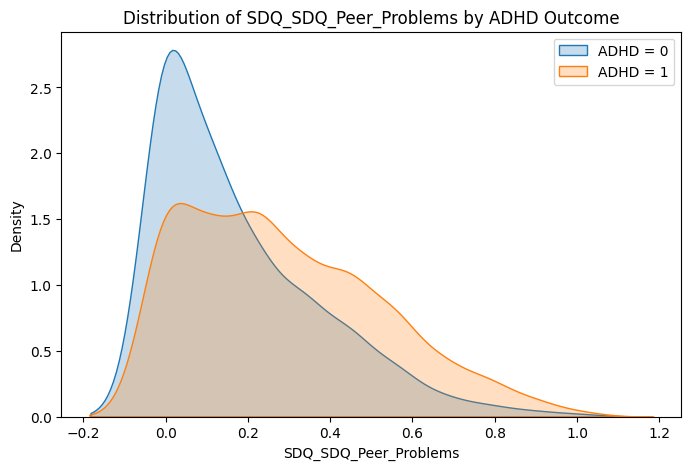

<ipython-input-37-03e497a9ebd7>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group0, label="ADHD = 0", shade=True)
<ipython-input-37-03e497a9ebd7>:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group1, label="ADHD = 1", shade=True)


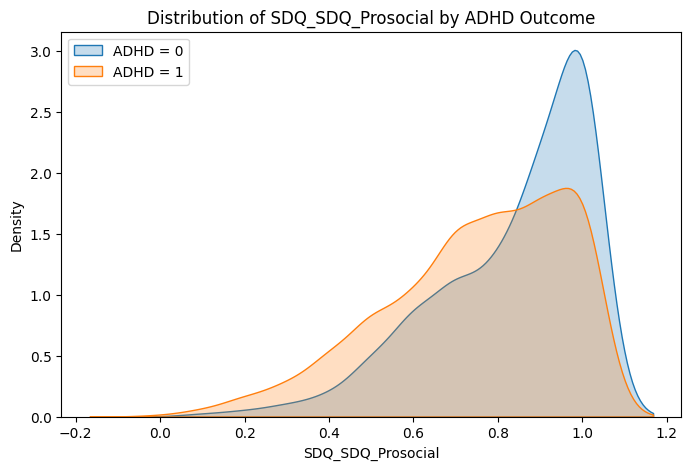

<ipython-input-37-03e497a9ebd7>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group0, label="ADHD = 0", shade=True)
<ipython-input-37-03e497a9ebd7>:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(group1, label="ADHD = 1", shade=True)


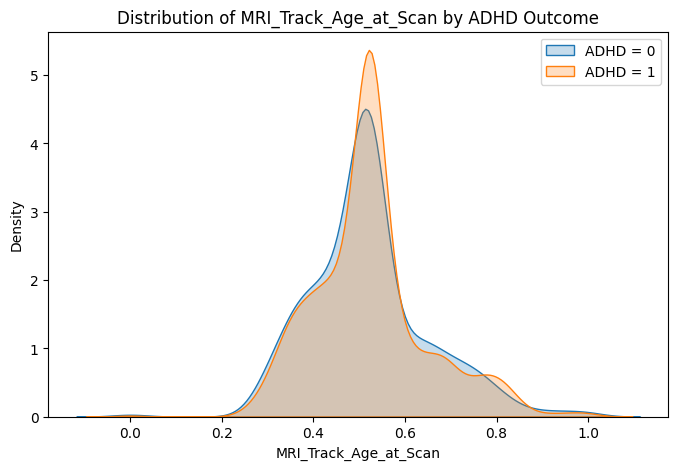

<Figure size 800x500 with 0 Axes>

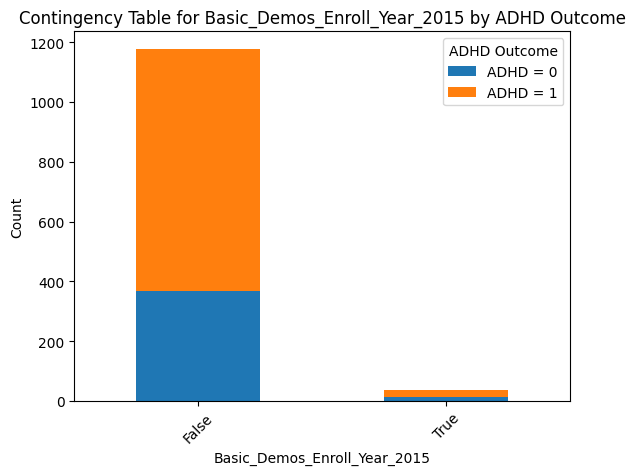

<Figure size 800x500 with 0 Axes>

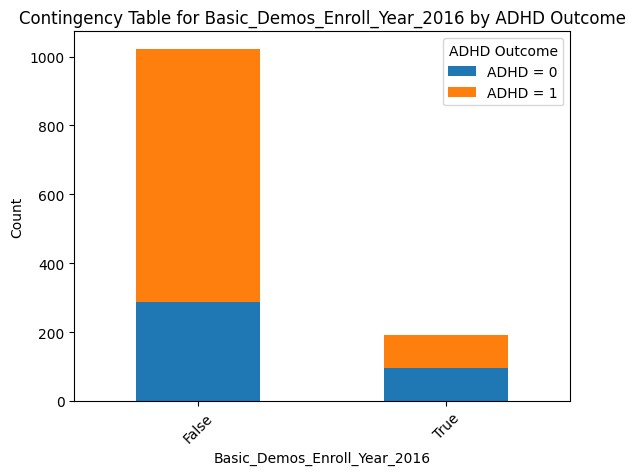

<Figure size 800x500 with 0 Axes>

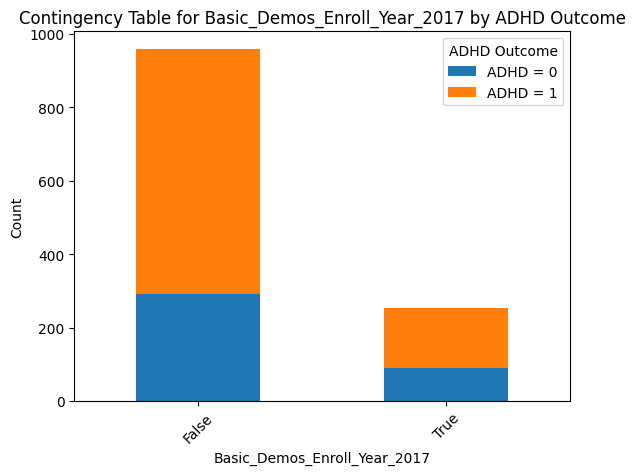

<Figure size 800x500 with 0 Axes>

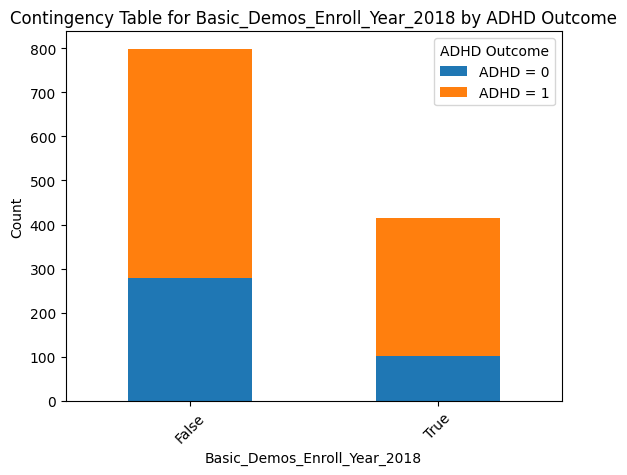

<Figure size 800x500 with 0 Axes>

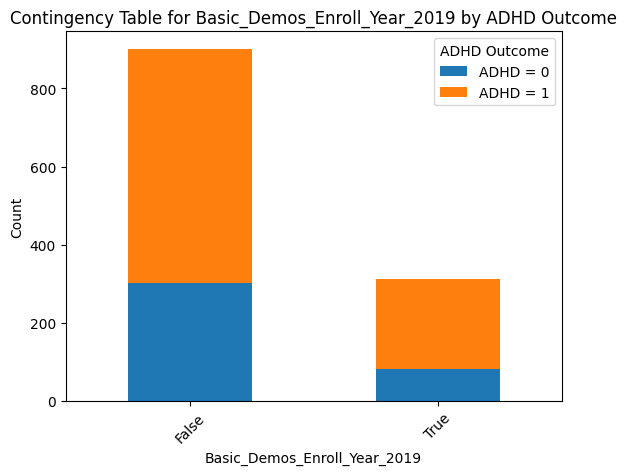

<Figure size 800x500 with 0 Axes>

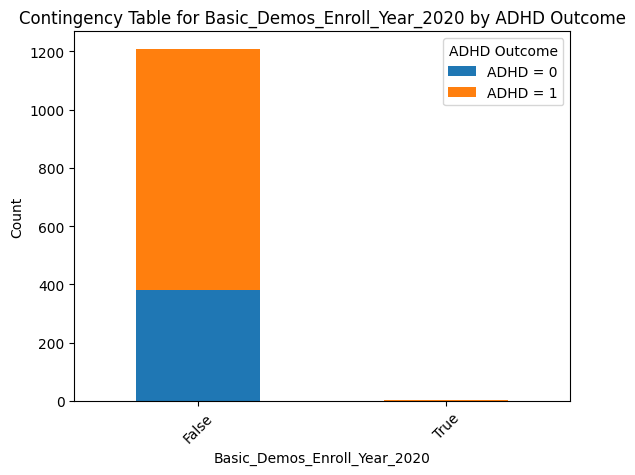

<Figure size 800x500 with 0 Axes>

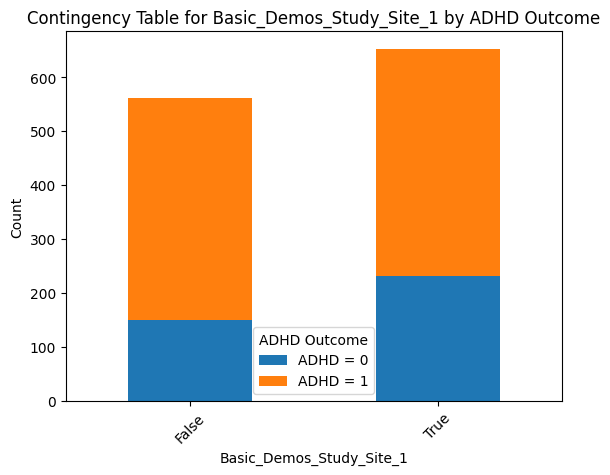

<Figure size 800x500 with 0 Axes>

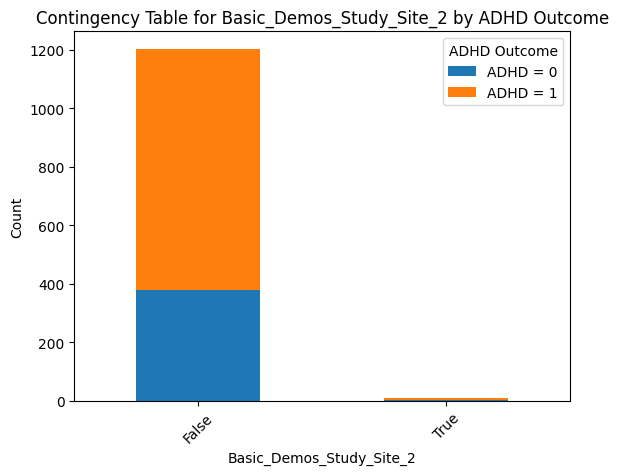

<Figure size 800x500 with 0 Axes>

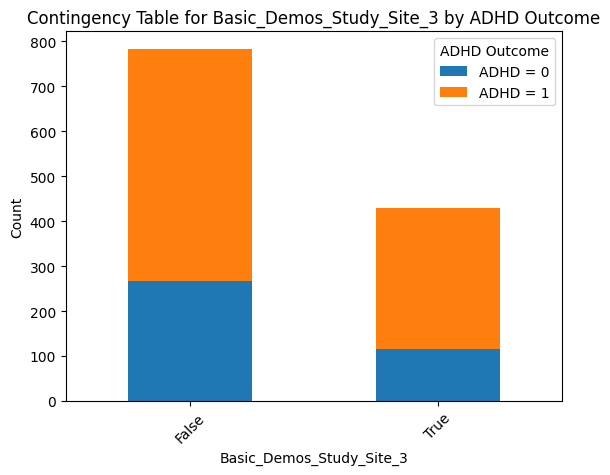

<Figure size 800x500 with 0 Axes>

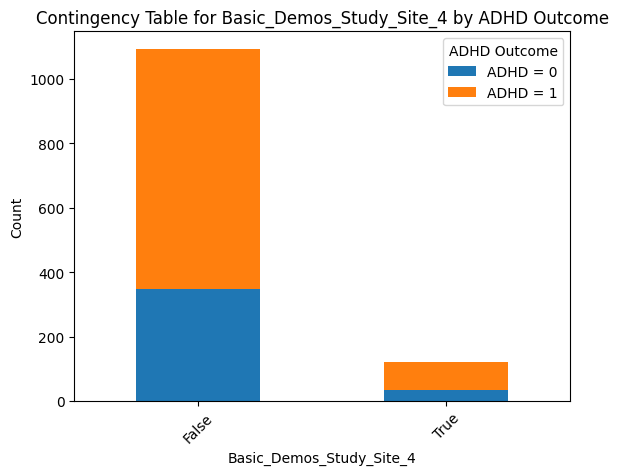

<Figure size 800x500 with 0 Axes>

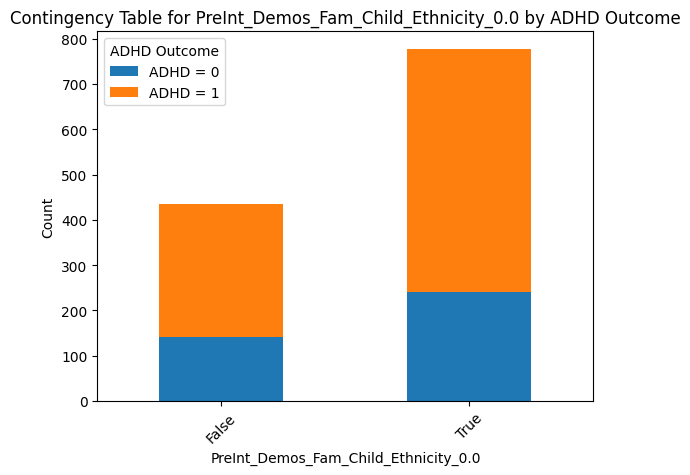

<Figure size 800x500 with 0 Axes>

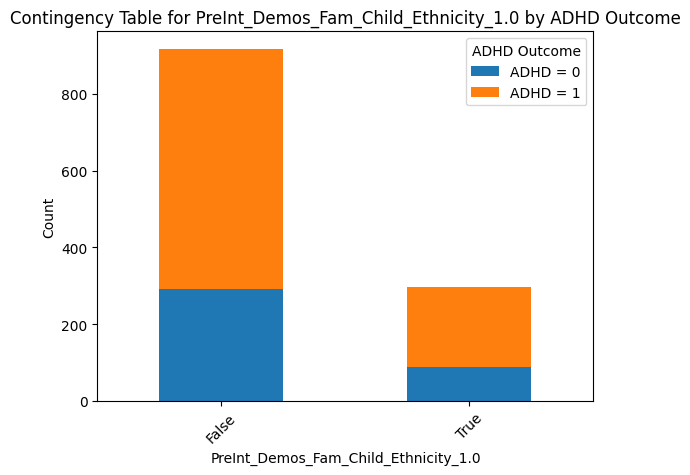

<Figure size 800x500 with 0 Axes>

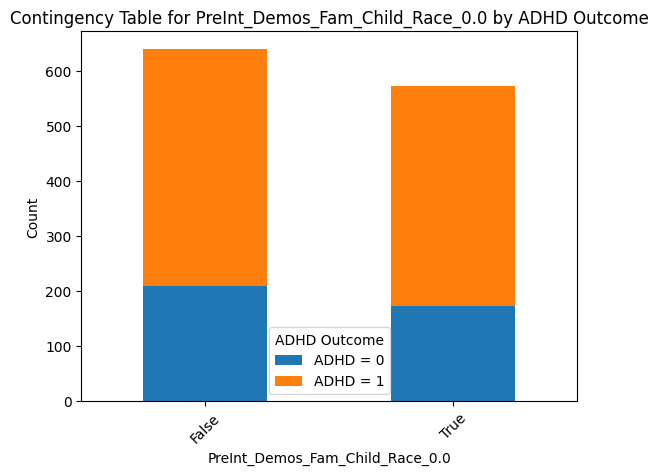

<Figure size 800x500 with 0 Axes>

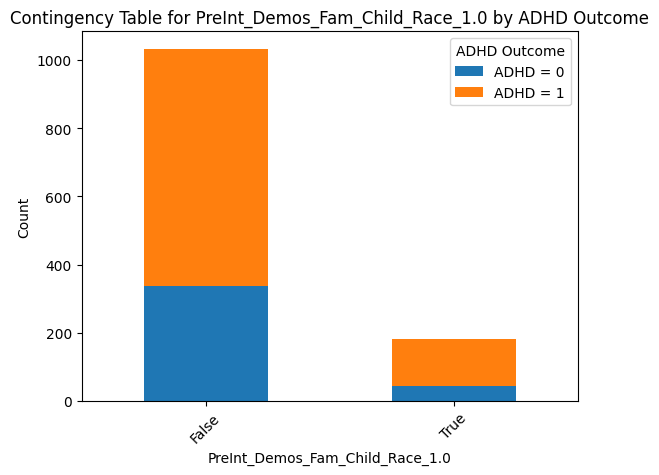

<Figure size 800x500 with 0 Axes>

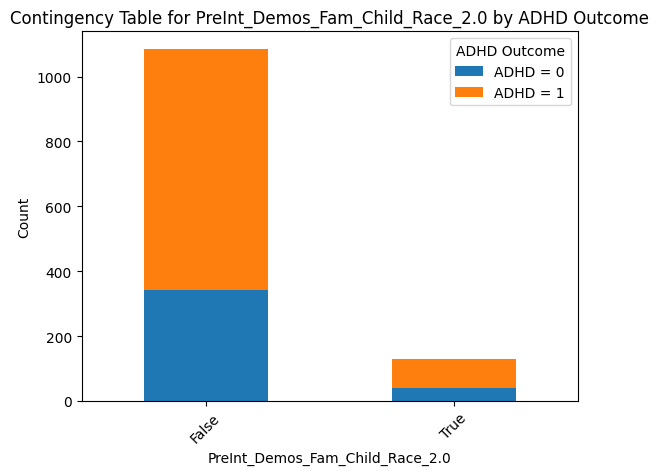

<Figure size 800x500 with 0 Axes>

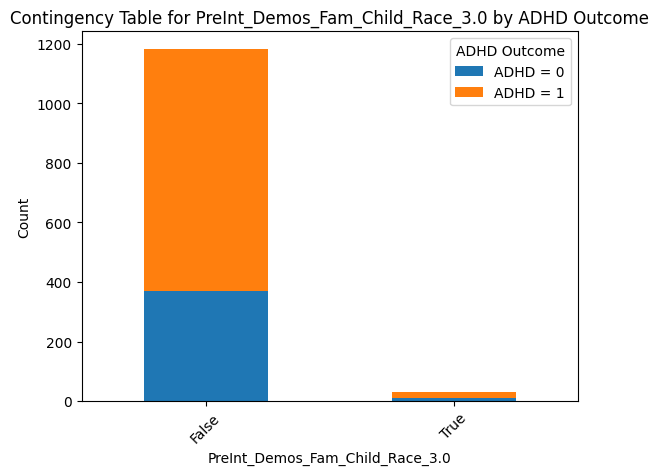

<Figure size 800x500 with 0 Axes>

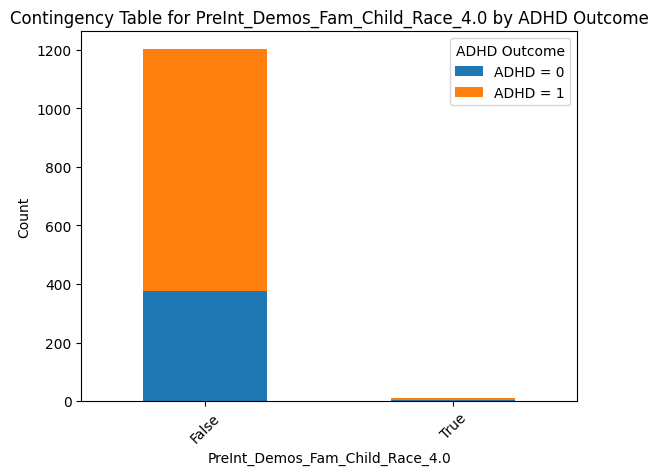

<Figure size 800x500 with 0 Axes>

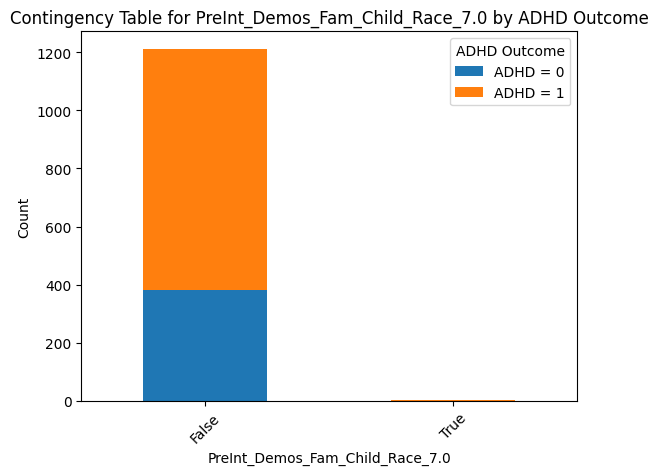

<Figure size 800x500 with 0 Axes>

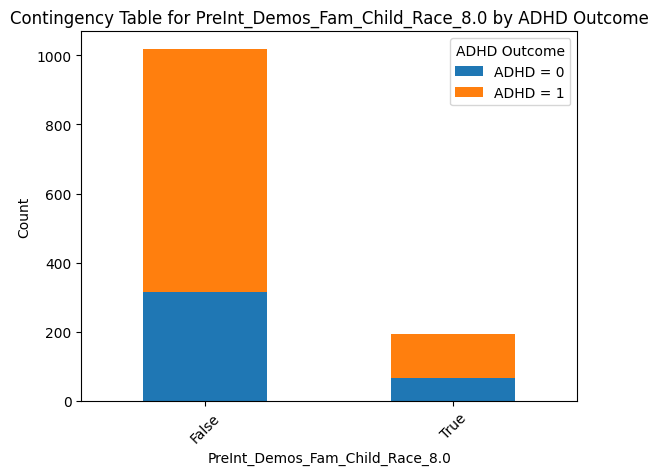

<Figure size 800x500 with 0 Axes>

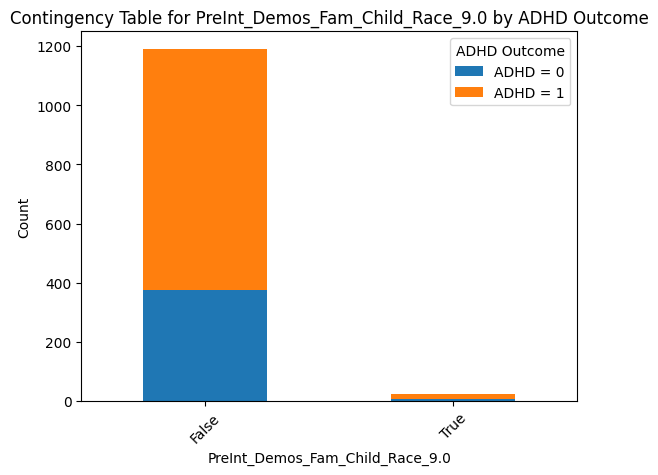

<Figure size 800x500 with 0 Axes>

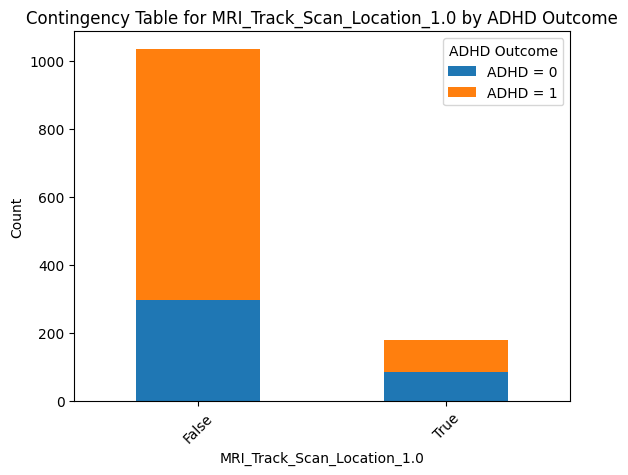

<Figure size 800x500 with 0 Axes>

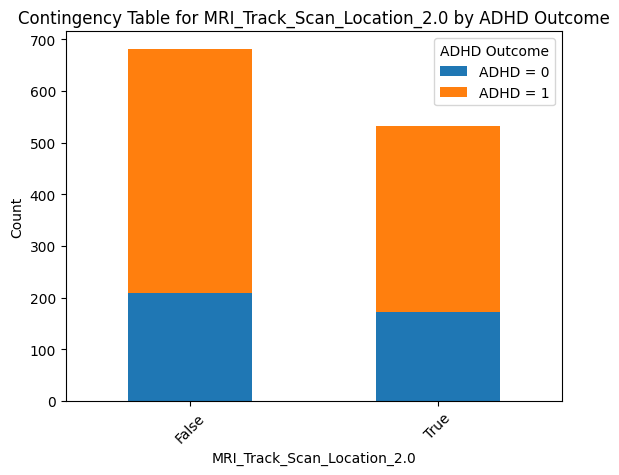

<Figure size 800x500 with 0 Axes>

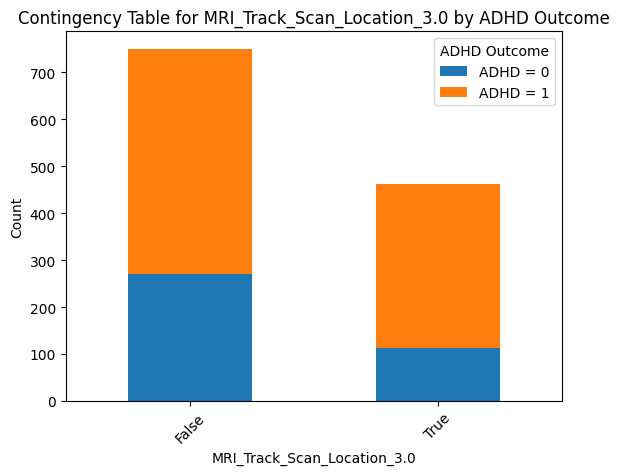

<Figure size 800x500 with 0 Axes>

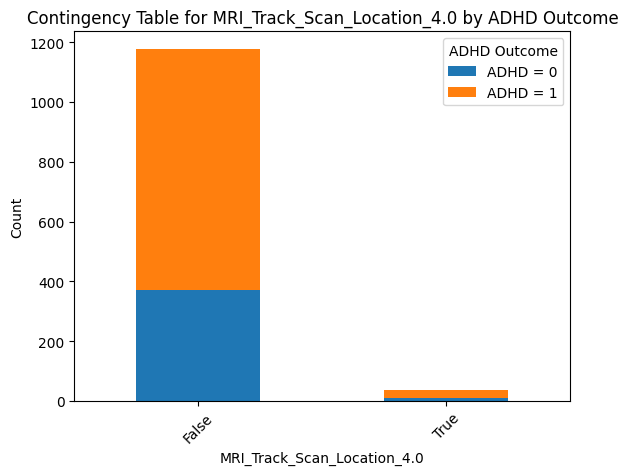

<Figure size 800x500 with 0 Axes>

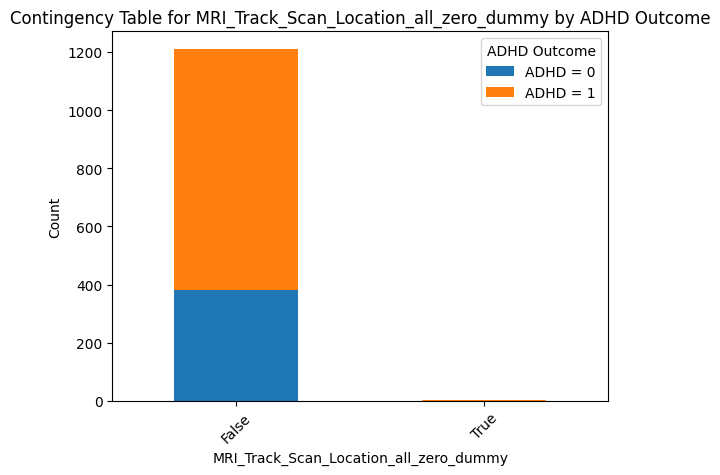

<Figure size 800x500 with 0 Axes>

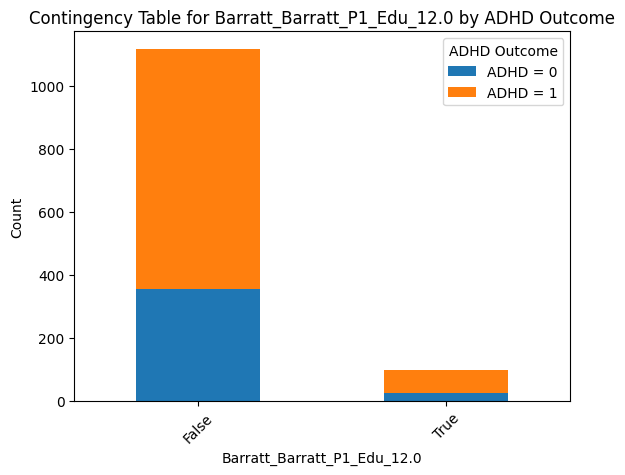

<Figure size 800x500 with 0 Axes>

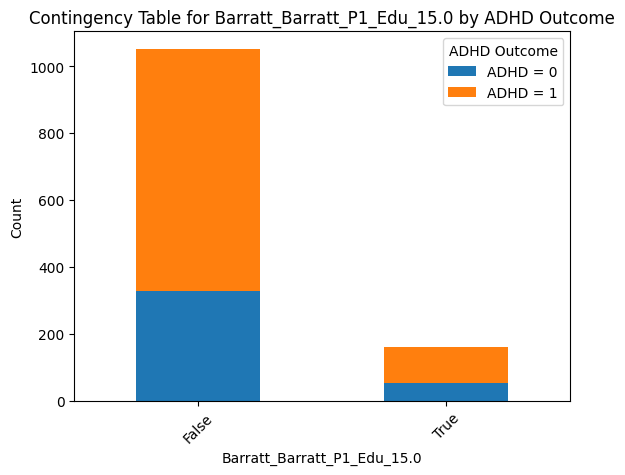

<Figure size 800x500 with 0 Axes>

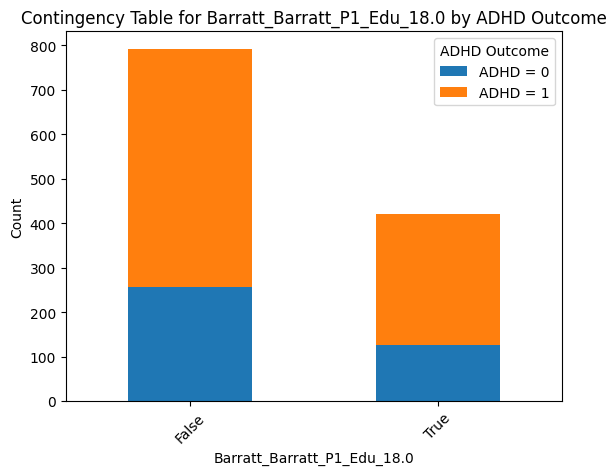

<Figure size 800x500 with 0 Axes>

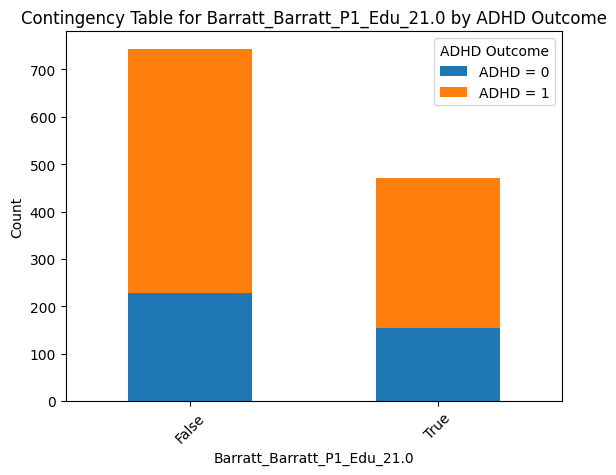

<Figure size 800x500 with 0 Axes>

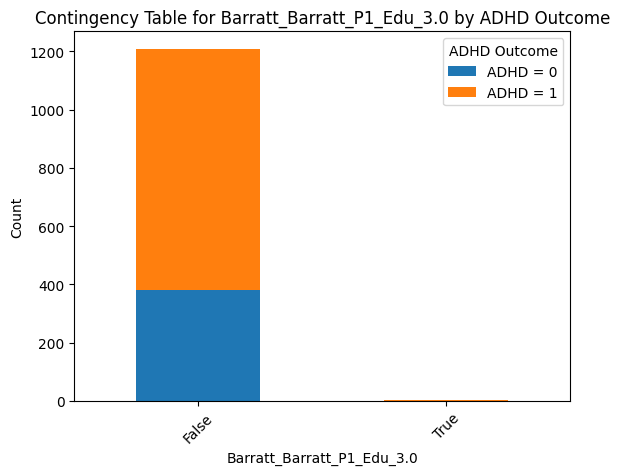

<Figure size 800x500 with 0 Axes>

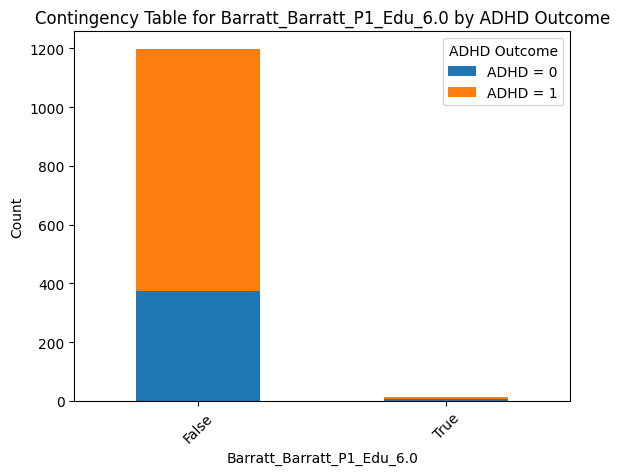

<Figure size 800x500 with 0 Axes>

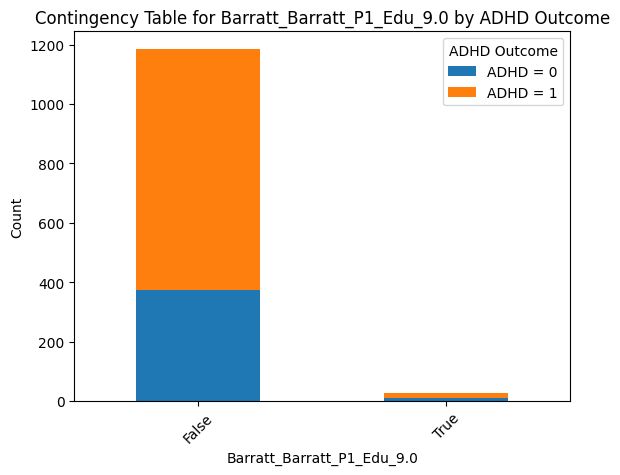

<Figure size 800x500 with 0 Axes>

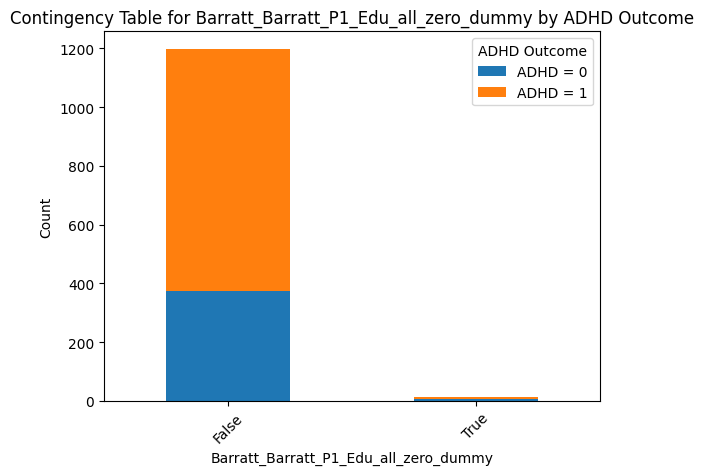

<Figure size 800x500 with 0 Axes>

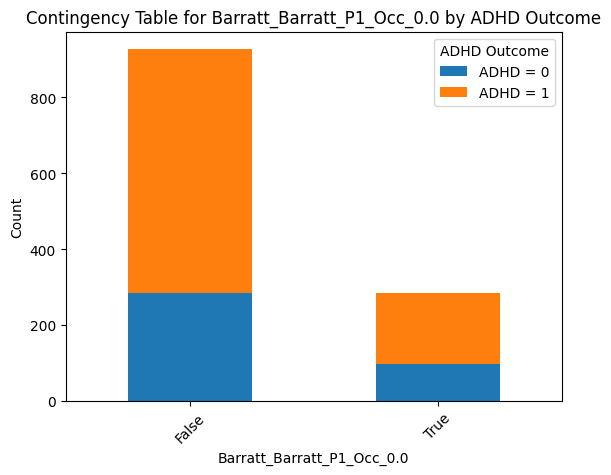

<Figure size 800x500 with 0 Axes>

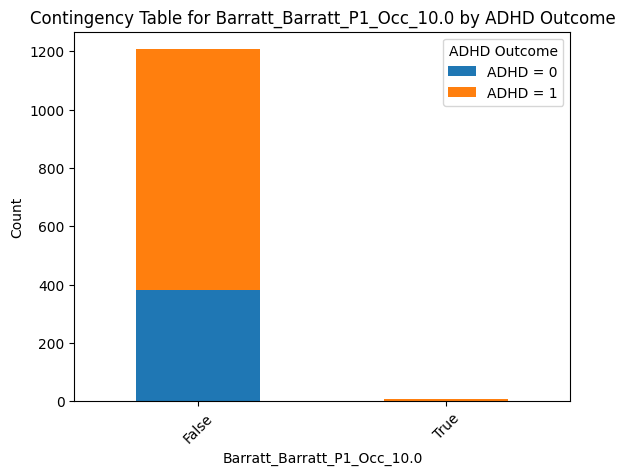

<Figure size 800x500 with 0 Axes>

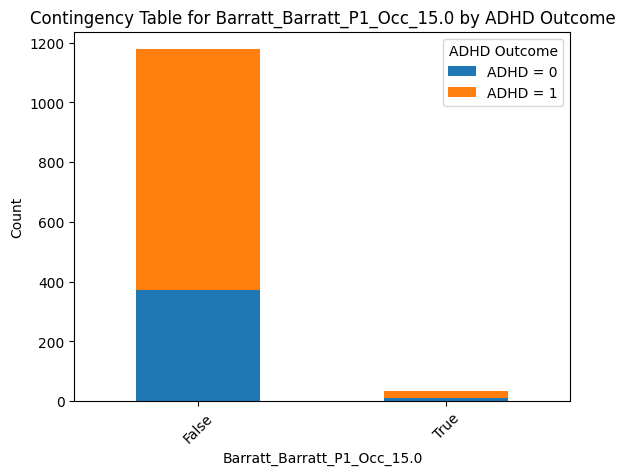

<Figure size 800x500 with 0 Axes>

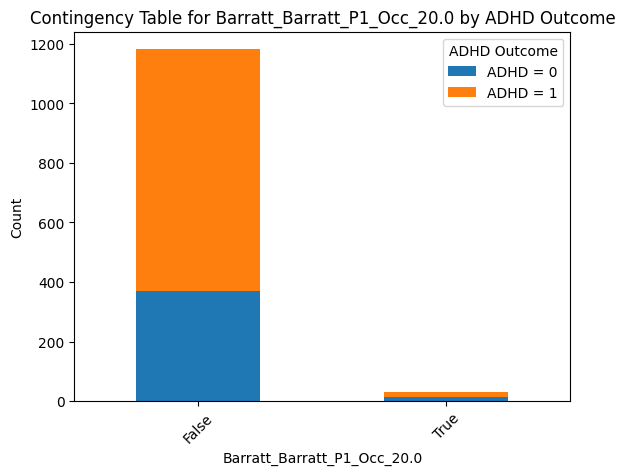

<Figure size 800x500 with 0 Axes>

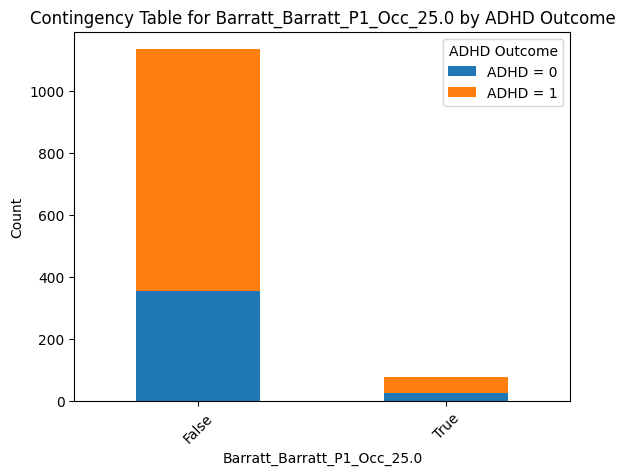

<Figure size 800x500 with 0 Axes>

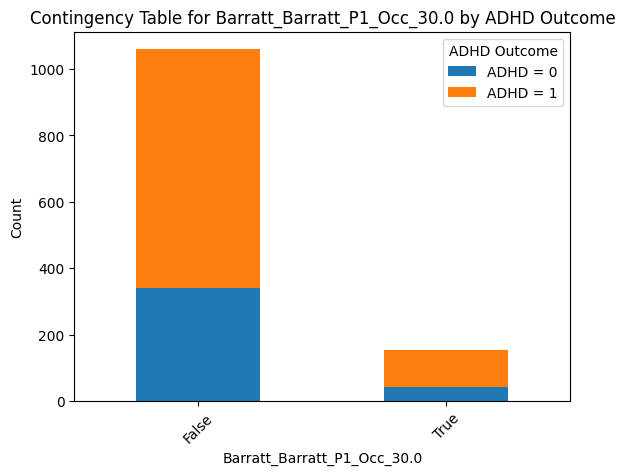

<Figure size 800x500 with 0 Axes>

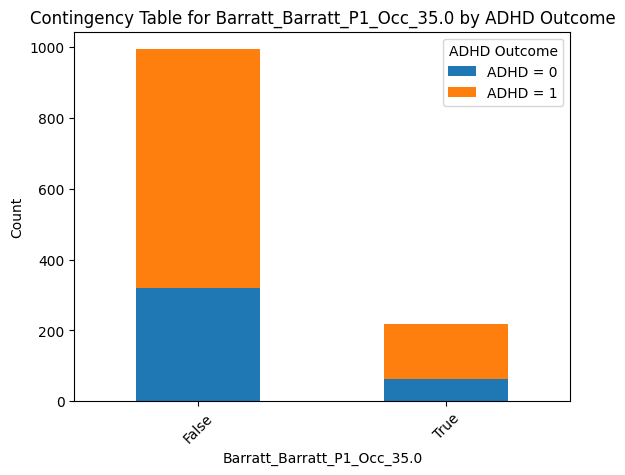

<Figure size 800x500 with 0 Axes>

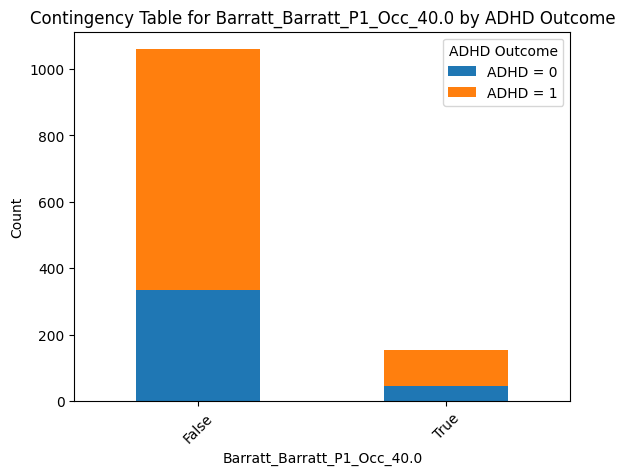

<Figure size 800x500 with 0 Axes>

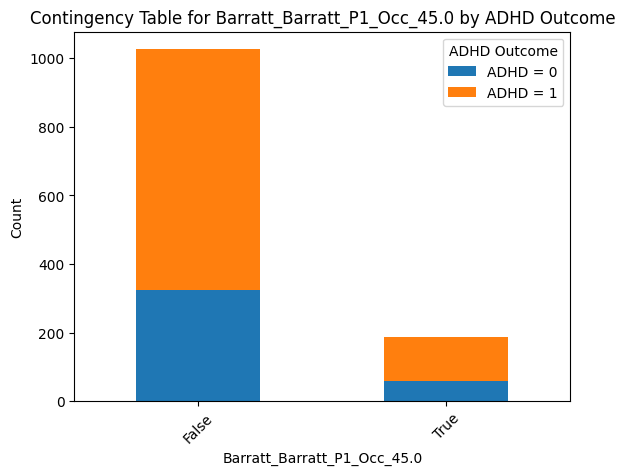

<Figure size 800x500 with 0 Axes>

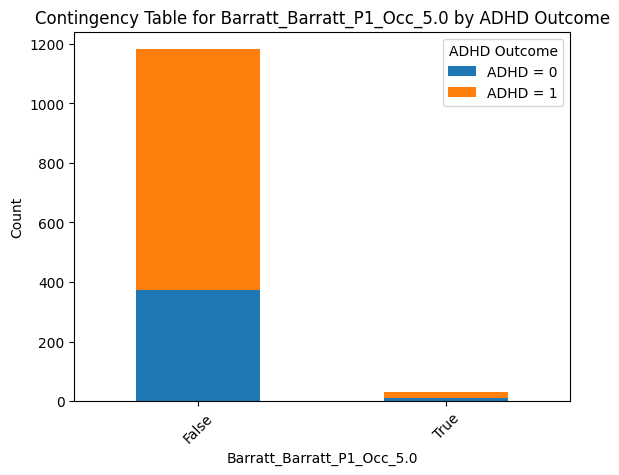

<Figure size 800x500 with 0 Axes>

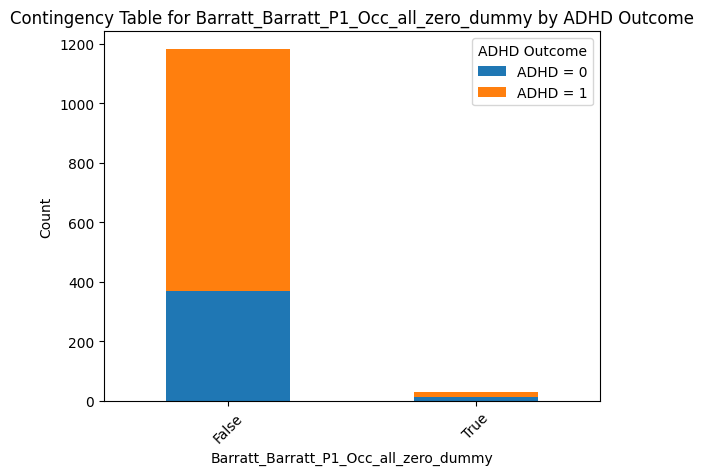

<Figure size 800x500 with 0 Axes>

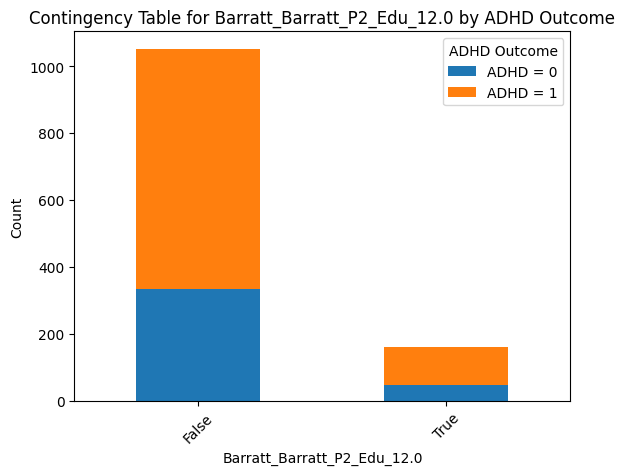

<Figure size 800x500 with 0 Axes>

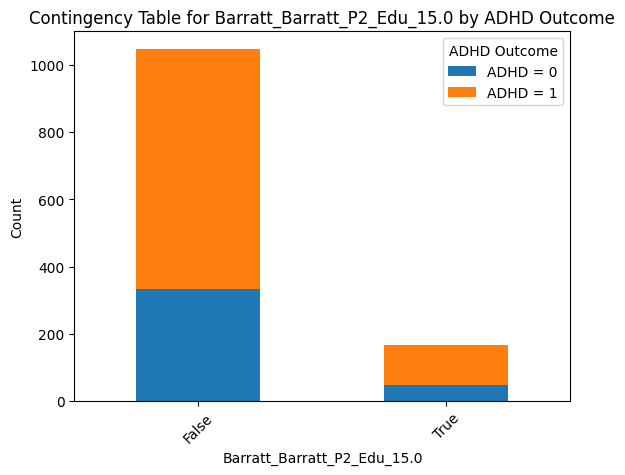

<Figure size 800x500 with 0 Axes>

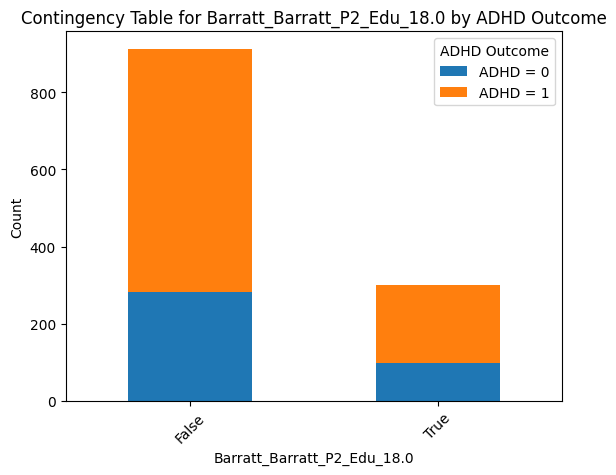

<Figure size 800x500 with 0 Axes>

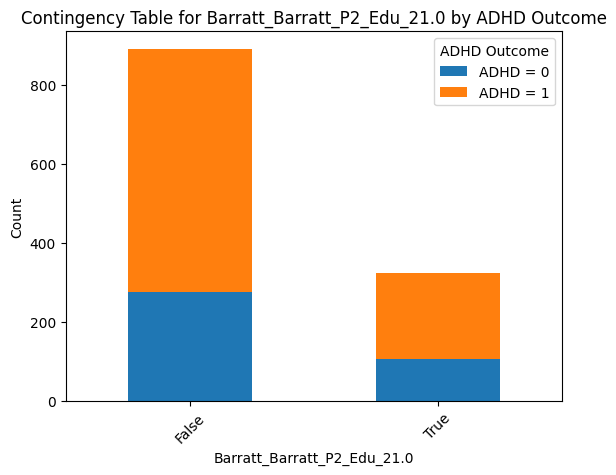

<Figure size 800x500 with 0 Axes>

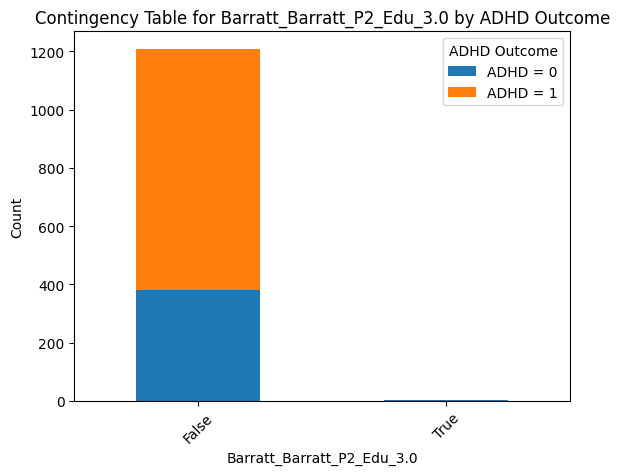

<Figure size 800x500 with 0 Axes>

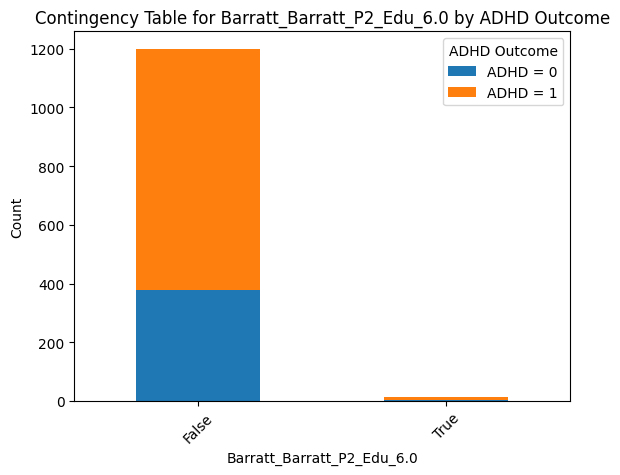

<Figure size 800x500 with 0 Axes>

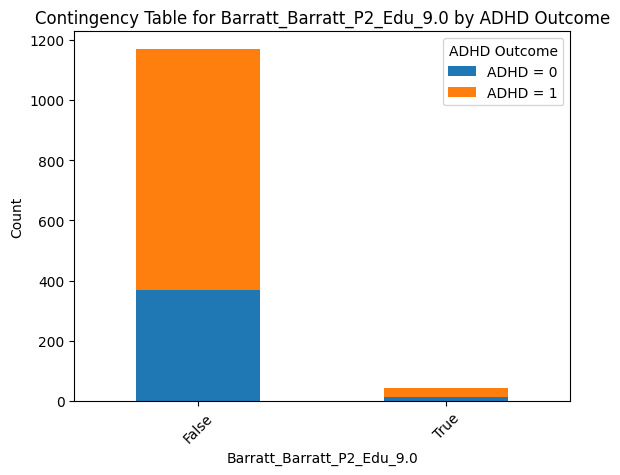

<Figure size 800x500 with 0 Axes>

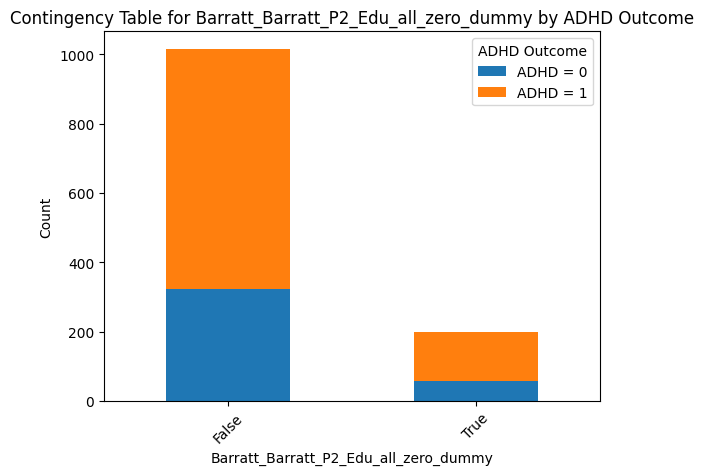

<Figure size 800x500 with 0 Axes>

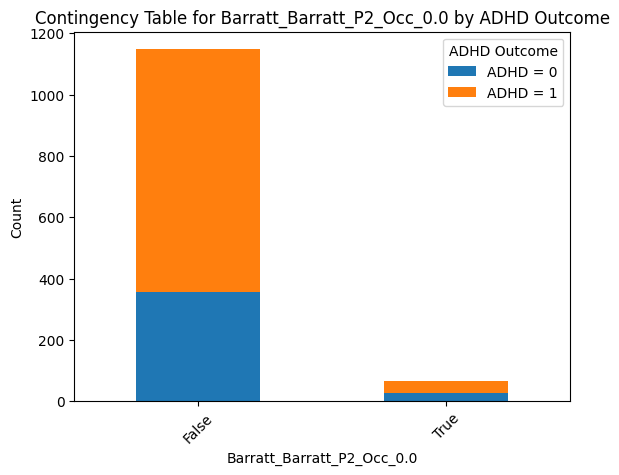

<Figure size 800x500 with 0 Axes>

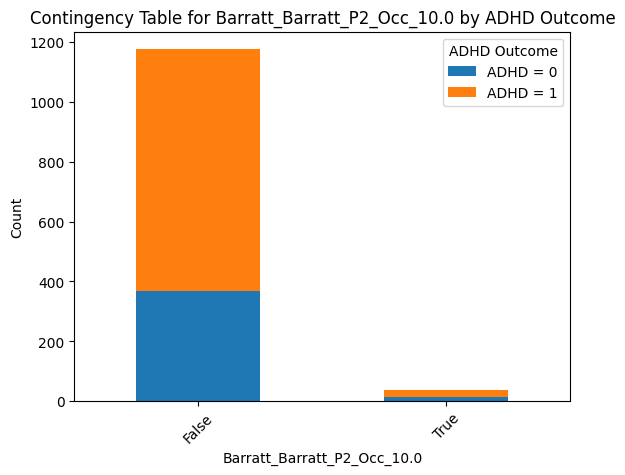

<Figure size 800x500 with 0 Axes>

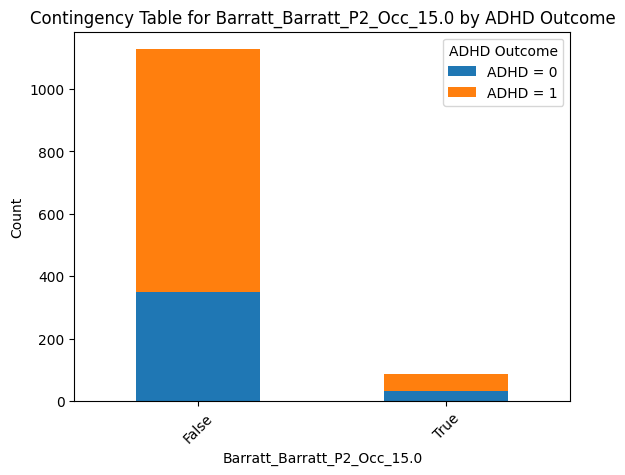

<Figure size 800x500 with 0 Axes>

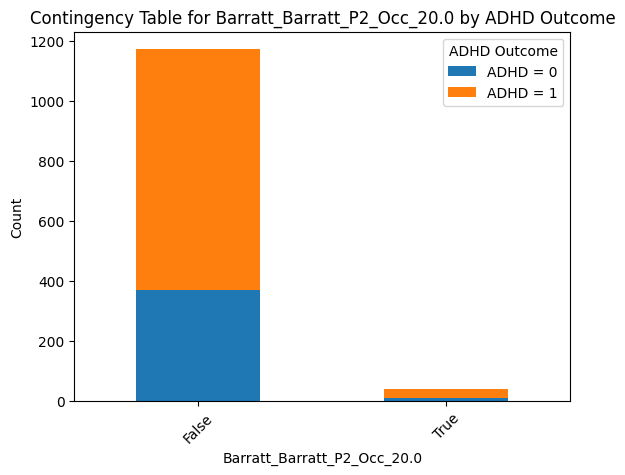

<Figure size 800x500 with 0 Axes>

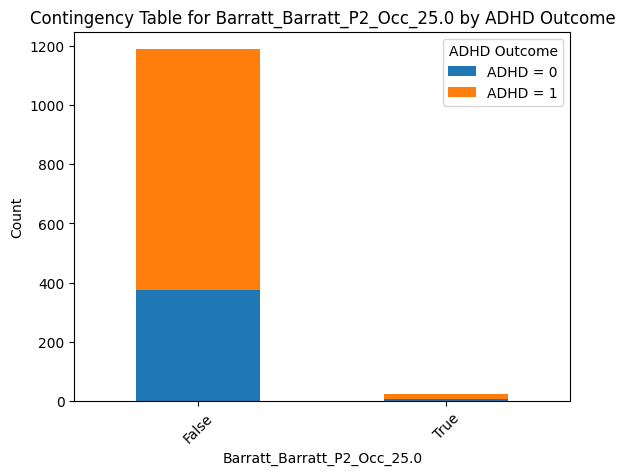

<Figure size 800x500 with 0 Axes>

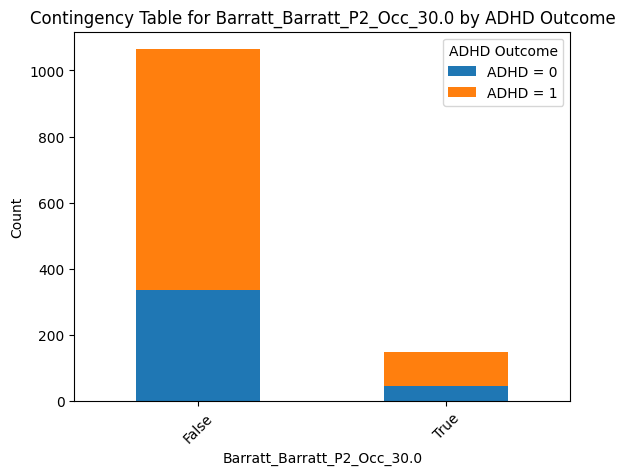

<Figure size 800x500 with 0 Axes>

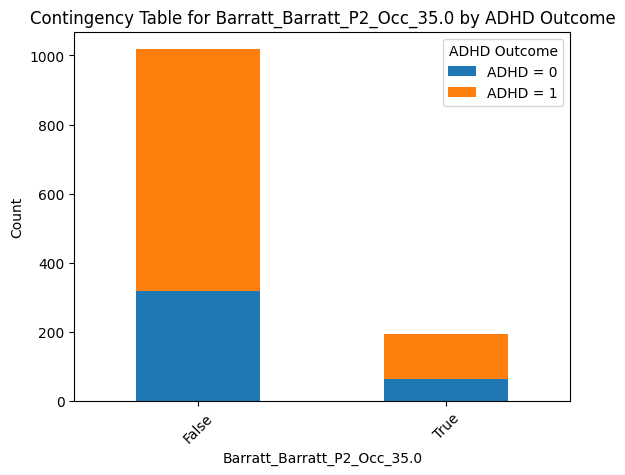

<Figure size 800x500 with 0 Axes>

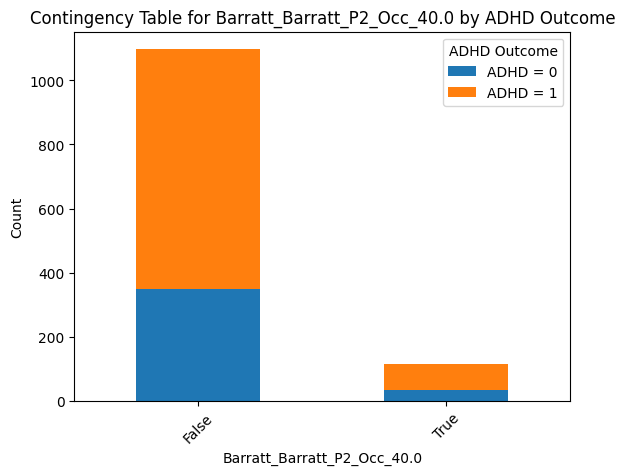

<Figure size 800x500 with 0 Axes>

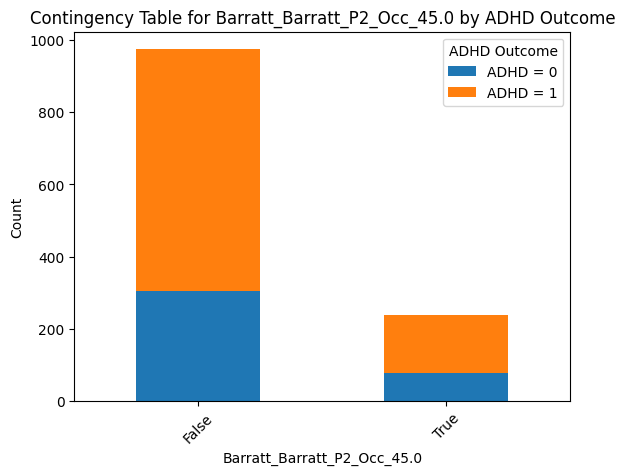

<Figure size 800x500 with 0 Axes>

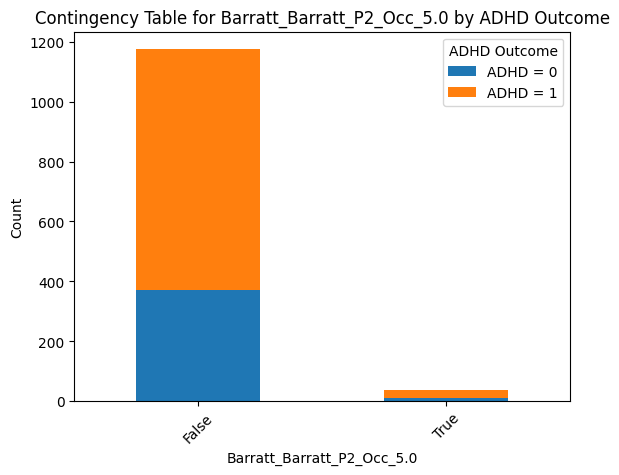

<Figure size 800x500 with 0 Axes>

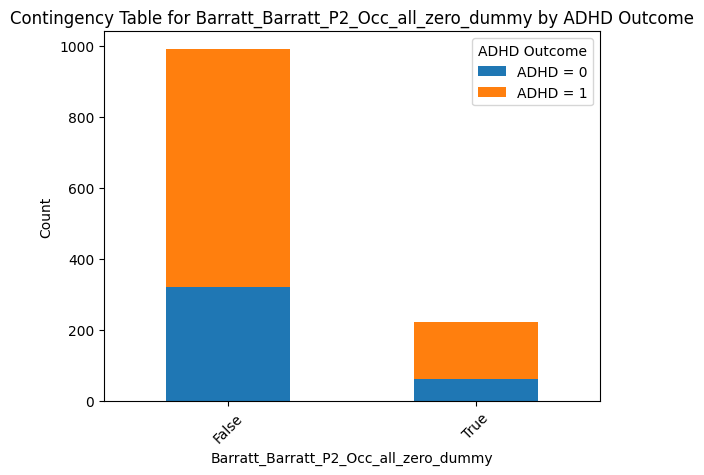

<Figure size 800x500 with 0 Axes>

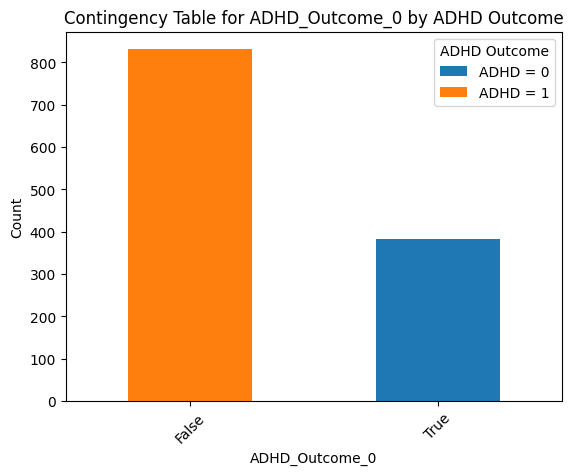

<Figure size 800x500 with 0 Axes>

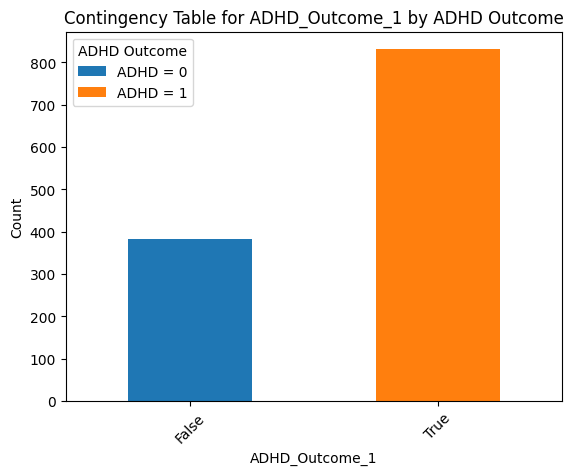

<Figure size 800x500 with 0 Axes>

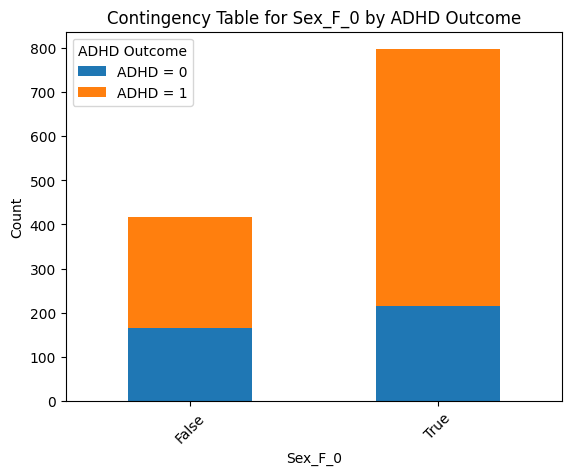

<Figure size 800x500 with 0 Axes>

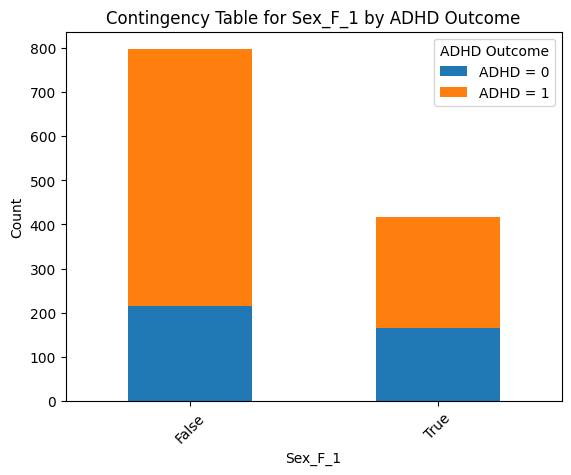


Checking if visualizations match statistical significance:
Quantitative feature APQ_P_APQ_P_OPD - Significance: Significant
Visualization for APQ_P_APQ_P_OPD shows a difference between ADHD Outcome 0 and 1.
Quantitative feature SDQ_SDQ_Internalizing - Significance: Significant
Visualization for SDQ_SDQ_Internalizing shows a difference between ADHD Outcome 0 and 1.
Quantitative feature SDQ_SDQ_Hyperactivity - Significance: Significant
Visualization for SDQ_SDQ_Hyperactivity shows a difference between ADHD Outcome 0 and 1.
Quantitative feature SDQ_SDQ_Generating_Impact - Significance: Significant
Visualization for SDQ_SDQ_Generating_Impact shows a difference between ADHD Outcome 0 and 1.
Quantitative feature SDQ_SDQ_Externalizing - Significance: Significant
Visualization for SDQ_SDQ_Externalizing shows a difference between ADHD Outcome 0 and 1.
Quantitative feature SDQ_SDQ_Emotional_Problems - Significance: Significant
Visualization for SDQ_SDQ_Emotional_Problems shows a difference betw

In [37]:

def plot_quantitative_results():
    for col in quant_features.columns:
        group0 = quant_merged[quant_merged[adhd_col] == 0][col].dropna()
        group1 = quant_merged[quant_merged[adhd_col] == 1][col].dropna()

        if len(group0) > 0 and len(group1) > 0:
            plt.figure(figsize=(8, 5))
            plt.title(f'Distribution of {col} by ADHD Outcome')
            sns.kdeplot(group0, label="ADHD = 0", shade=True)
            sns.kdeplot(group1, label="ADHD = 1", shade=True)
            plt.xlabel(col)
            plt.ylabel('Density')
            plt.legend()
            plt.show()

plot_quantitative_results()


def plot_categorical_results():
    for col in train_categorial.columns:
        if col == 'participant_id':
            continue

        contingency_table = pd.crosstab(cat_merged[col], cat_merged['ADHD_Outcome'])

        plt.figure(figsize=(8, 5))
        contingency_table.plot(kind='bar', stacked=True)
        plt.title(f'Contingency Table for {col} by ADHD Outcome')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.legend(title='ADHD Outcome', labels=["ADHD = 0", "ADHD = 1"])
        plt.show()

plot_categorical_results()

# Check if visualization matches statistics
def check_visualization_match_statistics():
    print("\nChecking if visualizations match statistical significance:")

    for feature in quant_stats_df['Feature']:
        significance = quant_stats_df.loc[quant_stats_df['Feature'] == feature, 'Significance'].values[0]
        print(f"Quantitative feature {feature} - Significance: {significance}")
        if significance == "Significant":
            print(f"Visualization for {feature} shows a difference between ADHD Outcome 0 and 1.")

    for feature in cat_stats_df['Feature']:
        significance = cat_stats_df.loc[cat_stats_df['Feature'] == feature, 'Significance'].values[0]
        print(f"Categorical feature {feature} - Significance: {significance}")
        if significance == "Significant":
            print(f"Visualization for {feature} shows a difference in counts between ADHD Outcome 0 and 1.")

check_visualization_match_statistics()


[Attached here our excel sheet with final features selected:](https://docs.google.com/spreadsheets/d/1rFeFCoPtSrC9U4q96uOp-bZYP889NvPOkGKI17jNtgQ/edit?gid=2143457203#gid=2143457203)